In [0]:
pip install --upgrade scikit-learn

Python interpreter will be restarted.
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Not uninstalling scikit-learn at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-2d1d2060-45c1-4f76-aacb-c8c5dfde21b2
    Can't uninstall 'scikit-learn'. No files were found to uninstall.
Python interpreter will be restarted.


In [0]:
from pyspark.sql.functions import *
from pyspark.ml.feature import *
from pyspark.ml.classification import *
from pyspark.ml import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import *
from pyspark.mllib.evaluation import *
import findspark
import pyspark
from pyspark import SparkContext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, RocCurveDisplay

In [0]:
findspark.init()
sc = SparkContext.getOrCreate()

In [0]:
meme_clean_sentiment = spark.read.parquet("/FileStore/meme_clean_sentiment")

In [0]:
meme_clean_sentiment.printSchema()

root
 |-- date: date (nullable = true)
 |-- stock: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- score: long (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- return: double (nullable = true)
 |-- if_name: boolean (nullable = true)
 |-- if_number: boolean (nullable = true)
 |-- text: string (nullable = true)
 |-- lemma: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- sentiment: string (nullable = true)



## Analysis I

### Balance Check

In [0]:
class1 = meme_clean_sentiment.select("stock","text").groupBy("stock").count().orderBy(col("stock"))
class1.show()

+-----+------+
|stock| count|
+-----+------+
|  AMC|115321|
|  BTC| 92258|
|  ETH| 48506|
|  GME|119884|
+-----+------+



In [0]:
class1 = class1.withColumn('class_weight', meme_clean_sentiment.count()/(4*col('count')))
class1.show()

+-----+------+------------------+
|stock| count|      class_weight|
+-----+------+------------------+
|  AMC|115321|0.8150488636068018|
|  BTC| 92258|1.0187978278306489|
|  ETH| 48506|1.9377448150744239|
|  GME|119884| 0.784026642421007|
+-----+------+------------------+



###Data Preparation

In [0]:
stock_sub = meme_clean_sentiment.select("stock","text").join(class1.select('stock','class_weight'), 
                                                             on=['stock'], how='left')
stock_sub.show(5)

+-----+--------------------+------------------+
|stock|                text|      class_weight|
+-----+--------------------+------------------+
|  AMC|I know Apes not s...|0.8150488636068018|
|  GME|Stock dividend se...| 0.784026642421007|
|  BTC|Hi !\n\nI've poss...|1.0187978278306489|
|  ETH|The small family ...|1.9377448150744239|
|  GME|Hey everyone -\n\...| 0.784026642421007|
+-----+--------------------+------------------+
only showing top 5 rows



In [0]:
# Regex tokenizer
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
# BOW count
countVectors = CountVectorizer(inputCol="words", outputCol="features", vocabSize=10000, minDF=5)
# String Indexer
stringIndex = StringIndexer(inputCol = "stock", outputCol = "label")
# One-Hot-Encoder on Labels
encoder = OneHotEncoder(inputCol = 'label', outputCol = 'categoryVec')
# Normalizing
normalizer = Normalizer(inputCol = 'features', outputCol = 'features_norm', p=1.0)
# Apply pipline
pipeline_log = Pipeline(stages=[regexTokenizer,
                                countVectors,
                                normalizer,
                                stringIndex,
                                encoder])
# Fit the pipeline
stock_classify = pipeline_log.fit(stock_sub).transform(stock_sub)
stock_classify.show(10)

+-----+--------------------+------------------+--------------------+--------------------+--------------------+-----+-----------+
|stock|                text|      class_weight|               words|            features|       features_norm|label|categoryVec|
+-----+--------------------+------------------+--------------------+--------------------+--------------------+-----+-----------+
|  ETH|The small family ...|1.9377448150744239|[the, small, fami...|(10000,[0,1,2,4,6...|(10000,[0,1,2,4,6...|  3.0|  (3,[],[])|
|  ETH|\nDirector purcha...|1.9377448150744239|[director, purcha...|(10000,[0,1,2,3,4...|(10000,[0,1,2,3,4...|  3.0|  (3,[],[])|
|  ETH|Hi. I've decided ...|1.9377448150744239|[hi, i, ve, decid...|(10000,[1,2,5,6,7...|(10000,[1,2,5,6,7...|  3.0|  (3,[],[])|
|  ETH|Felt compelled to...|1.9377448150744239|[felt, compelled,...|(10000,[0,1,2,3,4...|(10000,[0,1,2,3,4...|  3.0|  (3,[],[])|
|  ETH|If this is a brea...|1.9377448150744239|[if, this, is, a,...|(10000,[0,1,2,3,4...|(10000,[

In [0]:
# Partition training & testing set proportionally
train1 = stock_classify.sampleBy("label", fractions={0: 0.7, 1: 0.7, 2: 0.7, 3:0.7}, seed=42)
test1 = stock_classify.subtract(train1)

### Evaluation Metrics

In [0]:
def model_evaluate(predictions):
    eval_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", 
                                                      metricName="accuracy")
    eval_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", 
                                                metricName="f1")
    eval_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol='prediction', 
                                             metricName='areaUnderROC')
    
    accuracy = eval_accuracy.evaluate(predictions)
    f1score = eval_f1.evaluate(predictions)
    auc = eval_auc.evaluate(predictions)
    
    return {'accuracy':accuracy, 
            'f1_score':f1score,
            'auc':auc}

### Logistic Regression

#### Logsitic Reg using CountVectorizer

In [0]:
logreg = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0, weightCol='class_weight').fit(train1)
log_pred= logreg.transform(test1)
log_pred.select("text","stock","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-----+------------------------------+-----+----------+
|                          text|stock|                   probability|label|prediction|
+------------------------------+-----+------------------------------+-----+----------+
|Join Su p er s to n k Join ...|  GME|[1.0,5.504503982953875E-57,...|  0.0|       0.0|
|Imagine posting your positi...|  GME|[0.9999999999999993,2.12865...|  0.0|       0.0|
|SSR SSR SSR SSR SSR SSR SSR...|  GME|[0.999999999999998,1.956894...|  0.0|       0.0|
|       UPDATE 2 - ETF Rebal...|  GME|[0.9999999999994558,4.89550...|  0.0|       0.0|
| \n\nThis is an extension o...|  GME|[0.9999999999974356,2.90861...|  0.0|       0.0|
| \n\nThis is an extension o...|  GME|[0.9999999999973495,2.96295...|  0.0|       0.0|
|**TL;DR: (in order of impor...|  GME|[0.999999999996974,3.635727...|  0.0|       0.0|
|\*\*Warning: This is a very...|  GME|[0.9999999985838632,1.32170...|  0.0|       0.0|
|Link to post 1: [\n\n Part ...|  GME|[0.99

In [0]:
# evaluation metrics
metric_log = model_evaluate(log_pred)
print(metric_log)

{'accuracy': 0.6747159935763992, 'f1_score': 0.6660911014962935, 'auc': 0.7891442279313848}


#### Logistic Reg using TF-IDF

In [0]:
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)

pipeline_tfidf = Pipeline(stages=[regexTokenizer,
                                  hashingTF,
                                  idf,
                                  normalizer,
                                  stringIndex,
                                  encoder])

tfidf_df = pipeline_tfidf.fit(stock_sub).transform(stock_sub)

# Split dataset
train2 = tfidf_df.sampleBy("label", fractions={0: 0.7, 1: 0.7, 2: 0.7, 3: 0.7}, seed=42)
test2 = tfidf_df.subtract(train2)

# Fit model
logreg_tfidf = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0, weightCol='class_weight').fit(train2)
tfidf_pred = logistic_tfidf.transform(test2)
tfidf_pred.select("text","stock","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-----+------------------------------+-----+----------+
|                          text|stock|                   probability|label|prediction|
+------------------------------+-----+------------------------------+-----+----------+
|Link to post 1: [\n\n Part ...|  GME|[0.9999999998463327,1.66128...|  0.0|       0.0|
|       UPDATE 2 - ETF Rebal...|  GME|[0.9999999997795457,7.91391...|  0.0|       0.0|
| \n\nThis is an extension o...|  GME|[0.9999999994129325,7.45338...|  0.0|       0.0|
| \n\nThis is an extension o...|  GME|[0.9999999993959254,7.56894...|  0.0|       0.0|
|  \n\nTL:DR\n\nChess\n\nChe...|  GME|[0.9999999711765405,2.63418...|  0.0|       0.0|
|[\n\n **Usman Kabir Mon, Ju...|  GME|[0.9999999557096488,2.59391...|  0.0|       0.0|
|This article is a long time...|  GME|[0.9999998465606972,1.57602...|  0.0|       0.0|
|  Why Wall Street is Poised...|  GME|[0.9999994426592616,3.38650...|  0.0|       0.0|
|Not financial advice just p...|  GME|[0.99

In [0]:
# evaluation metrics
metric_tfidf = model_evaluate(tfidf_pred)
print(metric_tfidf)

{'accuracy': 0.6297715956690113, 'f1_score': 0.6100756211122668, 'auc': 0.7828570446517762}


#### Hyperparams Tuning with K-fold CV

In [0]:
# Choose logistic regression without TF-IDF features
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0, weightCol='class_weight')

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5])
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2])
             .build())

# Set evaluator for CrossValidator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator, 
                    numFolds=5)

# Fit model
CVmodel = cv.fit(train1)
CV_pred = CVmodel.transform(test1)

# Evaluate best model
metric_CV = model_evaluate(CV_pred)
print(metric_CV)

{'accuracy': 0.7132040408833007, 'f1_score': 0.7084089750559897, 'auc': 0.816537621252095}


### Random Forest

#### RF baseline

In [0]:
random_forest = RandomForestClassifier(labelCol="label",
                                       featuresCol="features",
                                       numTrees = 100,
                                       maxDepth = 5,
                                       maxBins = 24,
                                       weightCol='class_weight')
# Fit RF
RF = random_forest.fit(train1)

# Predict
rf_pred = RF.transform(test1)
rf_pred.select("text","stock","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-----+------------------------------+-----+----------+
|                          text|stock|                   probability|label|prediction|
+------------------------------+-----+------------------------------+-----+----------+
|Hello, Ape family! Ape Anna...|  GME|[0.6636399374642472,0.10879...|  0.0|       0.0|
|DD By Marcus Ray GME/AMC SA...|  GME|[0.6602824440562861,0.09964...|  0.0|       0.0|
|From u/HomeDepotHank69 Uncl...|  GME|[0.6593812255473706,0.10416...|  0.0|       0.0|
|       UPDATE 2 - ETF Rebal...|  GME|[0.6585922902190106,0.08469...|  0.0|       0.0|
|Okay fellow apes, I see a l...|  GME|[0.6520034045568874,0.11605...|  0.0|       0.0|
| Posted by: [\n\n GME Gang:...|  GME|[0.635439545301334,0.094223...|  0.0|       0.0|
|Welcome fellow GME Apes!\n\...|  GME|[0.6285310009577948,0.12768...|  0.0|       0.0|
|&amp;x200B;\n\n(Prerequiste...|  GME|[0.6276769223365974,0.09524...|  0.0|       0.0|
| \n\nThis is an extension o...|  GME|[0.62

In [0]:
# evaluation metrics
metric_rf = model_evaluate(rf_pred)
print(metric_rf)

{'accuracy': 0.6440207184231856, 'f1_score': 0.6424884306926939, 'auc': 0.7625855728481761}


#### Hyperparams Tuning with K-fold CV

In [0]:
rf = RandomForestClassifier(numTrees = 100,
                            maxDepth = 5,
                            maxBins = 24,
                            weightCol='class_weight')

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

cv = CrossValidator(estimator=rf, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

CVmodel2 = cv.fit(train1)
CV_pred2 = CVmodel2.transform(test1)

# Evaluate best model
metric_CV2 = model_evaluate(CV_pred2)
print(metric_CV2)

{'accuracy': 0.760929542645241, 'f1_score': 0.7570970620619664, 'auc': 0.8365461302889525}


### Model Comparison

In [0]:
# table
model1=['LR with CV', 'LR with TF-IDF', 'Fine-tuned LR', 'Random Forest','Fine-tuned RF']
metrics1 = [metric_log, metric_tfidf, metric_CV, metric_rf, metric_CV2]

perf1 = spark.createDataFrame([list(m.values()) for m in metrics1],
                             schema=list(metric_log.keys())).toPandas()
perf1.insert(0,'model',model1)
perf1

,model,accuracy,f1_score,auc
0,LR with CV,0.674716,0.666091,0.789144
1,LR with TF-IDF,0.629772,0.610076,0.782857
2,Fine-tuned LR,0.713204,0.708409,0.816538
3,Random Forest,0.644021,0.642488,0.762586
4,Fine-tuned RF,0.760930,0.757097,0.836546


In [0]:
#perf1.to_csv('../../data/csv/ml_anly1_perform.csv',index=False)

In [0]:
# save predictions to dbfs
pred_lr1 = CV_pred.select('label', 'prediction').withColumnRenamed('prediction','lr_pred')

pred_rf1 = CV_pred2.select('label', 'prediction').withColumnRenamed('prediction','rf_pred')

# pred_lr1.write.mode("overwrite").format('parquet').save("/FileStore/pred_lr1")
# pred_rf1.write.mode("overwrite").format('parquet').save("/FileStore/pred_rf1")

### Summary of ML Analysis

In [0]:
# check stock&label
CV_pred2.groupBy('stock','label').count().show()

+-----+-----+-----+
|stock|label|count|
+-----+-----+-----+
|  AMC|  1.0|31664|
|  GME|  0.0|30834|
|  BTC|  2.0|25469|
|  ETH|  3.0|12911|
+-----+-----+-----+



<Figure size 720x720 with 0 Axes>

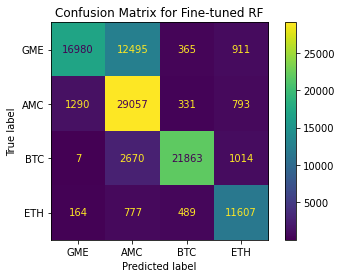

In [0]:
# CM for the best model
y_true = CV_pred2.select('label').collect()
y_pred = CV_pred2.select('prediction').collect()
CM = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(CM, display_labels=['GME','AMC','BTC','ETH'])
plt.figure(figsize = (10,10))
disp.plot()
plt.title("Confusion Matrix for Fine-tuned RF")
plt.savefig('../../data/plots/anly1_cm.png')
plt.show()

In [0]:
# table1
lr_true_count = CV_pred.groupBy('stock','label').count()
lr_pred_count = CV_pred.groupBy('prediction').count()
lr_truth = lr_true_count.withColumnRenamed('count','truth_count')
lr_pred = lr_pred_count.withColumnRenamed('count','pred_count')
lr_count = lr_truth.join(lr_pred).where(col('label')==col('prediction'))
lr_count = lr_count.withColumn('truth_percentage', col('truth_count')/(col('truth_count')+col('pred_count')))
lr_count = lr_count.withColumn('truth_percentage', round(col('truth_percentage'),3))
lr_count = lr_count.withColumn('pred_percentage', col('pred_count')/(col('truth_count')+col('pred_count')))
lr_count = lr_count.withColumn('pred_percentage', round(col('pred_percentage'),3))
lr_count = lr_count.drop('label','prediction').toPandas()
lr_count

,stock,truth_count,pred_count,truth_percentage,pred_percentage
0,AMC,31471,47882,0.397,0.603
1,GME,30751,18267,0.627,0.373
2,BTC,25554,21165,0.547,0.453
3,ETH,13037,13499,0.491,0.509


In [0]:
# save table1
#lr_count.to_csv('../../data/csv/ml_anly1_table1_lr.csv',index=False)

In [0]:
# table2
rf_true_count = CV_pred2.groupBy('stock','label').count()
rf_pred_count = CV_pred2.groupBy('prediction').count()
rf_truth = rf_true_count.withColumnRenamed('count','truth_count')
rf_pred = rf_pred_count.withColumnRenamed('count','pred_count')
rf_count = rf_truth.join(rf_pred).where(col('label')==col('prediction'))
rf_count = rf_count.withColumn('truth_percentage', col('truth_count')/(col('truth_count')+col('pred_count')))
rf_count = rf_count.withColumn('truth_percentage', round(col('truth_percentage'),3))
rf_count = rf_count.withColumn('pred_percentage', col('pred_count')/(col('truth_count')+col('pred_count')))
rf_count = rf_count.withColumn('pred_percentage', round(col('pred_percentage'),3))
rf_count = rf_count.drop('label','prediction').toPandas()
rf_count

,stock,truth_count,pred_count,truth_percentage,pred_percentage
0,GME,30751,18441,0.625,0.375
1,AMC,31471,44999,0.412,0.588
2,ETH,13037,14325,0.476,0.524
3,BTC,25554,23048,0.526,0.474


In [0]:
# save table2
#rf_count.to_csv('../../data/csv/ml_anly1_table2_rf.csv',index=False)

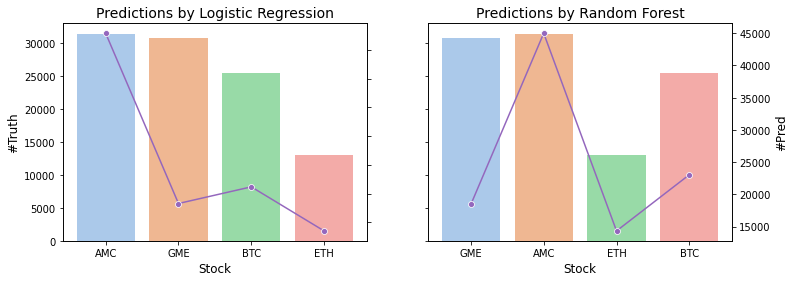

In [0]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (12,4), sharey=True)
sns.barplot(data=lr_count, x='stock', y='truth_count', ax=ax1, palette="pastel")
ax1.set_ylabel('#Truth', fontsize=12)
ax1.set_xlabel('Stock', fontsize=12)
ax2 = ax1.twinx()
sns.lineplot(data=lr_count, x='stock', y='pred_count', marker='o', color='tab:purple', ax=ax2)
ax2.set_ylabel('', fontsize=12)
ax2.set_yticklabels([])
ax2.set_title('Predictions by Logistic Regression', fontsize=14)

sns.barplot(data=rf_count, x='stock', y='truth_count', ax=ax3, palette="pastel")
ax3.set_ylabel('', fontsize=12)
ax3.set_xlabel('Stock', fontsize=12)
ax4 = ax3.twinx()
sns.lineplot(data=rf_count, x='stock', y='pred_count', marker='o', color='tab:purple', ax=ax4)
ax4.set_ylabel('#Pred', fontsize=12)
ax4.set_title('Predictions by Random Forest', fontsize=14)
plt.savefig('../../data/plots/anly1_pred_counts.png')
plt.show()

## Analysis II

### Data Preparation

In [0]:
meme_clean = spark.read.parquet("/FileStore/meme_clean_sentiment")

# add text length
meme_clean = meme_clean.withColumn("text_length", size(split('text',' ')))

In [0]:
meme_clean.count()

Out[4]: 375969

In [0]:
meme_indicator = sqlContext.createDataFrame(pd.read_csv('../../data/csv/meme_stock_indicators.csv'))\
    .select('Date','stock','mom','rsi','natr','cci','obv','adx','buy')

In [0]:
meme_indicator = meme_indicator.withColumn("Date", meme_indicator.Date.cast("date"))
meme_indicator = meme_indicator.withColumnRenamed('Date','date')
meme_indicator = meme_indicator.withColumnRenamed('buy','label')
meme_clean = meme_clean.join(meme_indicator, on=['date','stock'], how='left')


In [0]:
# clean data type
float_col = ['mom','rsi','natr','cci','obv','adx']
for c in float_col:
    meme_clean = meme_clean.withColumn(c, col(c).cast('float'))

meme_clean = meme_clean.withColumn('score', col('score').cast('int'))
meme_clean = meme_clean.withColumn('label', col('label').cast('int'))

In [0]:
meme_clean.printSchema()

root
 |-- date: date (nullable = true)
 |-- stock: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- return: double (nullable = true)
 |-- if_name: boolean (nullable = true)
 |-- if_number: boolean (nullable = true)
 |-- text: string (nullable = true)
 |-- lemma: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- sentiment: string (nullable = true)
 |-- text_length: integer (nullable = false)
 |-- mom: float (nullable = true)
 |-- rsi: float (nullable = true)
 |-- natr: float (nullable = true)
 |-- cci: float (nullable = true)
 |-- obv: float (nullable = true)
 |-- adx: float (nullable = true)
 |-- label: integer (nullable = true)



In [0]:
meme_clean = meme_clean.dropna()

In [0]:
meme_clean.count()

Out[10]: 375969

In [0]:
stringIndexer_senti = StringIndexer(inputCol="sentiment", 
                                    outputCol="sentiment_idx")

onehot_senti = OneHotEncoder(inputCol="sentiment_idx", 
                             outputCol="sentiment_vec")

stringIndexer_stock = StringIndexer(inputCol="stock", 
                                    outputCol="stock_idx")

onehot_stock = OneHotEncoder(inputCol="stock_idx", 
                             outputCol="stock_vec")

vectorAssembler = VectorAssembler(
    inputCols = ["text_length","score","sentiment_vec","stock_vec","mom","rsi","natr","cci",'obv','adx'],
    outputCol = "features") 

pipeline_2 = Pipeline(stages=[stringIndexer_senti, 
                              stringIndexer_stock, 
                              onehot_senti,
                              onehot_stock,
                              vectorAssembler])

return_classify = pipeline_2.fit(meme_clean).transform(meme_clean)

### Balance Check

In [0]:
class2 = return_classify.groupBy('label').count()
class2.show()

+-----+------+
|label| count|
+-----+------+
|    1|171039|
|    0|204930|
+-----+------+



In [0]:
class2 = class2.withColumn('class_weight', return_classify.count()/(2*col('count')))
class2.show()

+-----+------+------------------+
|label| count|      class_weight|
+-----+------+------------------+
|    1|171039|1.0990738954273587|
|    0|204930|0.9173107890499195|
+-----+------+------------------+



In [0]:
return_classify = return_classify.join(class2.select('label','class_weight'), 
                                       on=['label'], how='left')

return_classify.select('label','features','class_weight').show(5)

+-----+--------------------+------------------+
|label|            features|      class_weight|
+-----+--------------------+------------------+
|    1|[240.0,31.0,1.0,0...|1.0990738954273587|
|    1|[14.0,12.0,1.0,0....|1.0990738954273587|
|    0|[12.0,917.0,0.0,1...|0.9173107890499195|
|    0|[45.0,10.0,1.0,0....|0.9173107890499195|
|    0|[91.0,8.0,0.0,0.0...|0.9173107890499195|
+-----+--------------------+------------------+
only showing top 5 rows



In [0]:
# train test split
train3 = return_classify.sampleBy("label", fractions={0: 0.7, 1: 0.7}, seed=42)
test3 = return_classify.subtract(train3)

### Logistic Regression

In [0]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0, weightCol='class_weight')

lrparamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5])
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2])
             .build())
lrevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

lrcv = CrossValidator(estimator=lr,
                      estimatorParamMaps=lrparamGrid,
                      evaluator=lrevaluator, 
                      numFolds=3)

lrModel = lrcv.fit(train3)
lrPred = lrModel.transform(test3)

metric_lr2 = model_evaluate(lrPred)
print(metric_lr2)

{'accuracy': 0.5901216531847162, 'f1_score': 0.5883804171209643, 'auc': 0.5886334549302389}


### Gradient Boosting Tree

In [0]:
gb = GBTClassifier(labelCol="label", featuresCol="features", weightCol='class_weight')

gbparamGrid = (ParamGridBuilder()
             .addGrid(gb.maxDepth, [2, 5, 8])
             .addGrid(gb.maxBins, [10, 20, 40])
             .addGrid(gb.maxIter, [5, 10, 20])
             .build())

gbevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

gbcv = CrossValidator(estimator = gb,
                      estimatorParamMaps = gbparamGrid,
                      evaluator = gbevaluator,
                      numFolds = 3)

gbcvModel = gbcv.fit(train3)
gbPred = gbcvModel.transform(test3)

metric_gb = model_evaluate(gbPred)
print(metric_gb)

{'accuracy': 0.9384709711740468, 'f1_score': 0.9385545503394694, 'auc': 0.9397295238291903}


### SVM

In [0]:
svm = LinearSVC(labelCol="label", featuresCol="features").fit(train3)
svmPred = svm.transform(test3)

metric_svm = model_evaluate(svmPred)
print(metric_svm)

{'accuracy': 0.5959544036217377, 'f1_score': 0.5861056577987674, 'auc': 0.583158568894994}


### Model Comparison

In [0]:
# save predictions to hdfs

# lrPred.write.mode("overwrite").format('parquet').save("/FileStore/pred_lr2")
# gbPred.write.mode("overwrite").format('parquet').save("/FileStore/pred_gb2")
# svmPred.write.mode("overwrite").format('parquet').save("/FileStore/pred_svm2")

In [0]:
model2=['Fine-tuned LR', 'Fine-tuned GBT', 'SVM']
metrics2 = [metric_lr2, metric_gb, metric_svm]

perf2 = spark.createDataFrame([list(m.values()) for m in metrics2],
                              schema=list(metric_lr2.keys())).toPandas()
perf2.insert(0,'model',model2)
perf2.to_csv('../../data/csv/ml_anly2_perform.csv',index=False)
perf2

,model,accuracy,f1_score,auc
0,Fine-tuned LR,0.590122,0.588380,0.588633
1,Fine-tuned GBT,0.938471,0.938555,0.939730
2,SVM,0.595954,0.586106,0.583159


In [0]:
# roc
lrStats = lrPred.select("probability",'prediction','label').collect()
gbStats = gbPred.select("probability",'prediction','label').collect()
svmStats = svmPred.select('prediction','label').collect()

lrProb = [i[0][1] for i in lrStats]
lrPredLabel = [i[1] for i in lrStats]
lrTrueLabel = [i[2] for i in lrStats]

gbProb = [i[0][1] for i in gbStats]
gbPredLabel = [i[1] for i in gbStats]
gbTrueLabel = [i[2] for i in gbStats]

svmPredLabel = [i[0] for i in svmStats]
svmTrueLabel = [i[1] for i in svmStats]

In [0]:
fpr_lr, tpr_lr, _ = roc_curve(lrTrueLabel, lrProb)
auc_lr = auc(fpr_lr, tpr_lr)

fpr_gb, tpr_gb, _ = roc_curve(gbTrueLabel, gbProb)
auc_gb = auc(fpr_gb, tpr_gb)

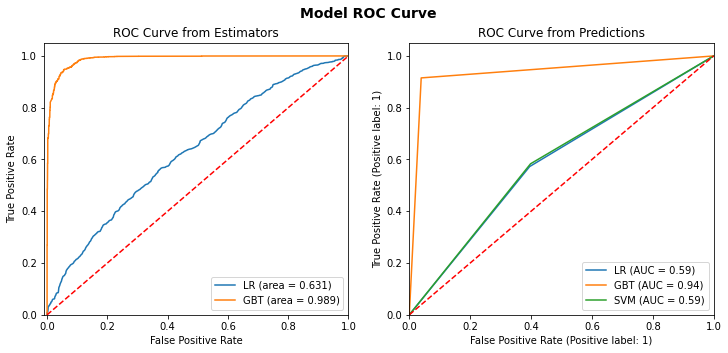

In [0]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
fig.suptitle('Model ROC Curve', fontweight='bold', fontsize=14)
ax1.plot(fpr_lr,tpr_lr, label="LR (area = %0.3f)" % auc_lr)
ax1.plot(fpr_gb,tpr_gb, label="GBT (area = %0.3f)" % auc_gb)
ax1.plot([0, 1], [0, 1], color="r", linestyle="--")
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlim([-0.01, 1.0])
ax1.set_ylim([0, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('ROC Curve from Estimators')

RocCurveDisplay.from_predictions(lrTrueLabel, lrPredLabel, ax=ax2, name='LR')
RocCurveDisplay.from_predictions(gbPredLabel, gbTrueLabel, ax=ax2, name='GBT')
RocCurveDisplay.from_predictions(svmPredLabel, svmTrueLabel, ax=ax2, name='SVM')
ax2.plot([0, 1], [0, 1], '--', color='r')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_title('ROC Curve from Predictions')
plt.savefig('../../data/plots/anly2_roc.png')
plt.show()

### Summary of ML Analysis

In [0]:
decision_by_senti = gbPred.groupBy('sentiment','prediction').count().toPandas()
decison_by_stock_senti = gbPred.groupBy('stock','sentiment','prediction').count().toPandas()

In [0]:
decision_by_senti_pivot = decision_by_senti.pivot(index='sentiment', 
                                                  columns='prediction',
                                                  values='count').reset_index()
decision_by_senti_pivot.columns =['Sentiment','Not Buy','Buy']
decision_by_senti_pivot.to_csv('../../data/csv/decisoin_by_senti.csv',index=False)
decision_by_senti_pivot

,Sentiment,Not Buy,Buy
0,negative,21501,18558
1,neutral,2605,2080
2,positive,34103,32060


In [0]:
decison_by_stock_senti_pivot = decison_by_stock_senti.pivot(index=['stock','sentiment'], 
                                                  columns='prediction',
                                                  values='count').reset_index()
decison_by_stock_senti_pivot.columns = ['Stock','Sentiment','Not Buy','Buy']
decison_by_stock_senti_pivot.to_csv('../../data/csv/decisoin_by_stock_senti.csv', index=False)
decison_by_stock_senti_pivot

,Stock,Sentiment,Not Buy,Buy
0,AMC,negative,7769,5857
1,AMC,neutral,1151,816
2,AMC,positive,10036,8509
3,BTC,negative,3902,4332
4,BTC,neutral,320,358
5,BTC,positive,8847,9642
6,ETH,negative,1888,2875
7,ETH,neutral,121,179
8,ETH,positive,3806,5406
9,GME,negative,7942,5494


<Figure size 720x720 with 0 Axes>

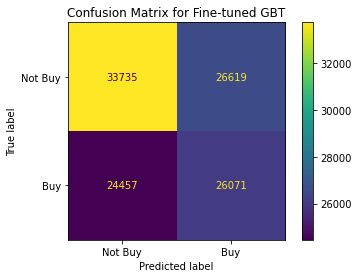

In [0]:
CM2 = confusion_matrix(gbTrueLabel, gbPredLabel)
disp = ConfusionMatrixDisplay(CM2, display_labels=['Not Buy','Buy'])
plt.figure(figsize = (10,10))
disp.plot()
plt.title("Confusion Matrix for Fine-tuned GBT")
#plt.savefig('../../data/plots/anly2_cm.png')
plt.show()